In [ ]:
# default_exp data.loadpandas

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai.basics import *
from fastai.data.transforms import *
from fastai.tabular.all import *
from fastseq.data.transforms import *

In [ ]:
# export
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [ ]:
# hide
from nbdev.showdoc import *

# Data

> Using the fastai `Datasets` to make an time series dataset.

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

## Storing data in a pandas DataFrame

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [ ]:
pd.DataFrame(data={'ts_0':[pd.Series(np.arange(10)),
                           pd.Series(np.arange(11))],
                   'ts_1':[pd.Series(np.arange(1,11)),
                           pd.Series(np.arange(1,12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})

,ts_0,ts_1,var_0,con_0
0,0 0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9 dtype: int64,0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9 10 dtype: int64,0.0,0
1,0 0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9 10 10 dtype: int64,0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9 10 10 11 dtype: int64,1.0,1


The `TSDataLoader` will work just like a regular `TabularDataLoaders` only it can handle `cols` to be timeseries(`pd.Series`).

In [ ]:
#export
def CategoryBlock(vocab=None, add_na=False):
    "`TransformBlock` for single-label categorical targets"
    return TransformBlock(type_tfms=Categorize(vocab=vocab, add_na=add_na))

In [ ]:
#export
class Tabular(CollBase, GetAttr, FilteredBase):
    "A `DataFrame` wrapper that knows which cols are cont/cat/ts/y, and returns rows in `__getitem__`"
    _default,with_cont='procs',True
    def __init__(self, df, procs=None, cat_names=None, cont_names=None, ts_names=None, y_names=None, block_y=CategoryBlock, splits=None,
                 do_setup=True, device=None):
        if splits is None: splits=[range_of(df)]
        df = df.iloc[sum(splits, [])].copy()
        self.dataloaders = delegates(self._dl_type.__init__)(self.dataloaders)
        super().__init__(df)

        self.y_names,self.device = L(y_names),device
        if block_y is not None:
            if callable(block_y): block_y = block_y()
            procs = L(procs) + block_y.type_tfms
        self.cat_names,self.cont_names,self.procs = L(cat_names),L(cont_names),Pipeline(procs, as_item=True)
        self.split = len(splits[0])
        if do_setup: self.setup()

    def subset(self, i): return self.new(self.items[slice(0,self.split) if i==0 else slice(self.split,len(self))])
    def copy(self): self.items = self.items.copy(); return self
    def new(self, df): return type(self)(df, do_setup=False, block_y=None, **attrdict(self, 'procs','cat_names','cont_names','y_names', 'device'))
    def show(self, max_n=10, **kwargs): display_df(self.all_cols[:max_n])
    def setup(self): self.procs.setup(self)
    def process(self): self.procs(self)
    def loc(self): return self.items.loc
    def iloc(self): return _TabIloc(self)
    def targ(self): return self.items[self.y_names]
    def all_col_names (self): return self.cat_names + self.cont_names + self.y_names
    def n_subsets(self): return 2
    def new_empty(self): return self.new(pd.DataFrame({}, columns=self.items.columns))
    def to_device(self, d=None):
        self.device = d
        return self

properties(Tabular,'loc','iloc','targ','all_col_names','n_subsets')

In [ ]:
from fastai.data.all import *

class Addition(Transform):
    def __init__(self, addition):
        store_attr( 'addition')        
    def encodes(self, o):
        return o + self.addition
    def decodes(self, o):
        return o - self.addition
        
@delegates(TfmdDL.__init__)
class MyDataLoader(TfmdDL):
    def __init__(self, dataset, **kwargs):    
        super().__init__(dataset=dataset, **kwargs)       
       
        
dl = MyDataLoader([1,2,3,4], after_item=[Addition(2)])

dl_new = dl.new()
test_eq(dl.one_batch(),dl_new.one_batch())

tensor([3, 4, 5, 6])


In [ ]:
# export
from fastai.data.all import *

class CreateItemsAdd(Transform):
    def __init__(self, addition=None): 
        store_attr('addition')
        
    def setup(self, *args, **kwargs):
        self.add = self.addition
        
    def encodes(self, o):
        return o + self.add
    
    def decodes(self, o):
        return o - self.add
     

In [ ]:
@delegates(TfmdDL.__init__)
class MyDataLoader(TfmdDL):
    def __init__(self, dataset, **kwargs):  
        
        if 'create_item' in kwargs:
            if hasattr(kwargs['create_item'],'setup'):
                kwargs['create_item'].setup()
                
        super().__init__(dataset=dataset, **kwargs)       
       
        
dl = MyDataLoader([1,2,3,4], create_item=CreateTSItems())

dl_new = dl.new()
test_eq(dl.one_batch(),dl_new.one_batch())
    

# Dataloader

In [ ]:
# export
# TODO maybe incl. start where the last one ended and therefor keep hidden state
@delegates(TfmdDL.__init__)
class TSDataLoader(TfmdDL):
    def __init__(self, dataset, bs=64, norm=True,
                 num_workers=0, create_item=None, **kwargs):  
        res = super().__init__(dataset=self.dataset, bs=bs, num_workers=num_workers **kwargs)
        
        self.dataset = L(dataset).map(tensor)
        self.norm_items(dataset, norm)
        n = self.make_ids()   
        print(self.dataset, horizon, lookback, step)     
        after_batch = ifnone(after_batch, noop)
        after_item = ifnone(after_item, noop)
        self.n = n
        
    def norm_items(self, dataset, norm):
        dataset = dataset.map(tensor)
        r = L()
        for i,ts in enumerate(dataset):
            ts = ts.float()
            if norm:
                ts = (ts - torch.mean(ts.float(), -1, keepdim = True))/(torch.std(ts.float(), -1, keepdim = True)+1e-8)            
            r.append(ts)
        return r
    
    @delegates(DataLoader.new)
    def new(self, dataset=None, cls=None, **kwargs):
        res = super().new(dataset, cls, do_setup=False, **kwargs)
        res.create_item.setup(dataset)
        if not hasattr(self, '_n_inp') or not hasattr(self, '_types'):
            try: 
                self._one_pass()
                res._n_inp,res._types = self._n_inp,self._types
            except: print("Could not do one pass in your dataloader, there is something wrong in it")
        return res
    
    def make_ids(self):        
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        print(self.dataset,self.horizon,self.lookback,self.step)
        for i, ts in enumerate(self.dataset):
            if isinstance(ts,tuple):
                ts = ts[0] # no idea why they become tuples 
            num_examples = (ts.shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts.shape[-1] < self.horizon:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts.shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1                
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))
        
        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
    def get_id(self,idx):        
        # Get time series
        ts_id, lookback_id = self._ids[idx]
        ts = self.dataset[ts_id]
        if isinstance(ts,tuple):
            ts = ts[0] # no idea why they become tuples 
        # Prepare input and target. Zero pad if necessary.
        if ts.shape[-1] < self.lookback + self.horizon:
            # If the time series is too short, we zero pad
            x = ts[:, :-self.horizon]
            x = np.pad(
                x, 
                pad_width=((0, 0), (self.lookback - x.shape[-1], 0)), 
                mode='constant', 
                constant_values=0
            )         
            y = ts[:,-self.horizon:]
        else:
            x = ts[:,lookback_id:lookback_id + self.lookback]
            y = ts[:,lookback_id + self.lookback:lookback_id + self.lookback + self.horizon]
        return x, y
        
    def shuffle_fn(self, idxs):
        self.dataset.shuffle()
        return idxs

    def create_item(self, idx):
        if idx>=self.n: raise IndexError
        x, y = self.get_id(idx)
        return TSTensorSeq(x),TSTensorSeqy(y, x_len=x.shape[1], m='-*g')


In [ ]:
# hide

horizon,lookback = 2,5
ints = L(np.arange(7)[None,:],np.arange(7,15)[None,:],np.arange(15,25)[None,:]).map(tensor)
dl = TSDataLoader(ints, horizon, lookback, bs = 2)
test_eq(dl.n, len(dl._ids))
test_eq(dl.n, 7)
test_eq(len(dl),4)    
horizon,lookback = 2,5
print('---')
ints = L(np.arange(10)[None,:],np.arange(20,30)[None,:],np.arange(40,50)[None,:])
dl = TSDataLoader(ints, horizon, lookback, bs=6, shuffle=True)

test_eq(dl.n, len(dl._ids))
test_eq(dl.n, 12)
test_eq(len(dl), 2)

print('---')
dl_new = dl.new()
test_eq(dl_new.lookback,dl.lookback)

test_eq(dl_new.n, dl.n)
test_eq(len(dl_new), len(dl))

(#3) [tensor([[0, 1, 2, 3, 4, 5, 6]]),tensor([[ 7,  8,  9, 10, 11, 12, 13, 14]]),tensor([[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]])] 2 5 1
(#3) [tensor([[0, 1, 2, 3, 4, 5, 6]]),tensor([[ 7,  8,  9, 10, 11, 12, 13, 14]]),tensor([[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]])] 2 5 1
---
(#3) [tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),tensor([[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]),tensor([[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])] 2 5 1
(#3) [tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),tensor([[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]),tensor([[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])] 2 5 1
---
(#3) [tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),tensor([[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]),tensor([[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])] 18.0 72 1
Dropped 3/3 time series due to length.
(#3) [tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),tensor([[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]),tensor([[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]])] 18.0 72 1


AssertionError: ==:
72
5

In [ ]:
# hide
horizon,lookback = 2,5
ints = L(np.arange(7)[None,:],np.arange(7,15)[None,:],np.arange(15,20)[None,:],np.arange(20,29)[None,:]).map(tensor)
dl = TSDataLoader(ints, horizon, lookback, norm=False)
test_eq(L(dl)[0][0][0,0].dtype,torch.float)
test_eq(
    L(dl),
    [(tensor([[[ 0.,  1.,  2.,  3.,  4.]],
        [[ 7.,  8.,  9., 10., 11.]],
        [[ 8.,  9., 10., 11., 12.]],
        [[ 0.,  0., 15., 16., 17.]],
        [[20., 21., 22., 23., 24.]],
        [[21., 22., 23., 24., 25.]],
        [[22., 23., 24., 25., 26.]]]), 
      tensor([[[ 5.,  6.]],
              [[12., 13.]],
              [[13., 14.]],
              [[18., 19.]],
              [[25., 26.]],
              [[26., 27.]],
              [[27., 28.]]
             ]
            ))])

Need to pad 1/4 time series due to length.


In [ ]:
horizon,lookback = 2,5
ints = L(np.arange(9)[None,:],np.arange(9,14)[None,:]).map(tensor)
ints

(#2) [tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8]]),tensor([[ 9, 10, 11, 12, 13]])]

In [ ]:
dl = TSDataLoader(ints, horizon, lookback, step=2, norm=False)
test_eq(list(dl),[(tensor([[[ 0.,  1.,  2.,  3.,  4.]],
                           [[ 2.,  3.,  4.,  5.,  6.]],
                           [[ 0.,  0.,  9., 10., 11.]]]),
                   tensor([[[ 5.,  6.]],
                           [[ 7.,  8.]],
                           [[12., 13.]]]))]
       )

Need to pad 1/2 time series due to length.


The first sequence (0 to 7) is transformed in to two items. One with x from 0 to 5 and y from 6 to 7. 
The next one is shifted just two, because `step` == 2. Note the second sequence is not long enough and is therefore padded with `0`'s.

In [ ]:
# hide
ints = L(np.arange(7)[None,:]).map(tensor)
dl = TSDataLoader(ints, horizon, lookback, shuffle=True, norm=True)
xy = tuple(dl)
test_eq(type(xy[0][0]), TSTensorSeq)
test_eq(xy[0][1].shape,(1,1,horizon))
test_close(torch.cat([xy[0][0][0,0,:],xy[0][1][0,0,:]]).mean(),0)

# Showing

In [ ]:
# export

from fastai.vision.data import *

@typedispatch
def show_batch(x: TensorSeq, y, samples, ctxs=None, max_n=10,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    ctxs = show_batch[object](x, y, samples=samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs


In [ ]:
#export
@typedispatch
def show_results(x: TensorSeq, y, samples, outs, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    for i in range(len(samples[0])):
        ctxs = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs,range(max_n))]
    for i in range(len(outs[0])):
        ctxs = [TSTensorSeqy(b ,m='*r', label='pred', x_len=x.shape[-1]).show(ctx=c, **kwargs) for b,c,_ in zip(outs.itemgot(i),ctxs,range(max_n))]
    return ctxs

# Intergration Example

In [ ]:
from fastseq.core import *
from fastai.basics import *

In [ ]:
path = untar_data(URLs.m4_daily)
df_train = pd.read_csv(path/'train.csv',nrows=100)
df_test = pd.read_csv(path/'val.csv')
df_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,D1,2039.20,2035.00,2051.80,2061.8,2063.50,2069.5,2054.00,2057.00,2062.80,2066.40,2067.40,2071.40,2083.80,2080.60
1,D2,2986.00,3001.20,2975.90,2996.1,2981.90,2985.5,2975.80,2956.20,2964.70,2989.00,2991.40,3024.90,3070.80,3076.90
2,D3,1120.70,1117.90,1115.10,1112.3,1109.50,1106.7,1103.90,1101.10,1098.30,1095.50,1092.70,1089.90,1087.10,1084.30
3,D4,1190.00,1162.00,1134.00,1106.0,1078.00,1050.0,1022.00,994.00,966.00,938.00,910.00,1428.00,1400.00,1372.00
4,D5,5904.67,5917.05,5922.58,5928.8,5935.29,6002.8,6009.47,6014.82,6020.19,6072.49,6077.72,6080.23,6082.75,6108.07


In [ ]:
horizon = 14
lookback = 128

items = ts_lists(df_train.iloc[:,1:].values)
splits = RandomSplitter()(items)

dsrc = Datasets(items, splits=splits, dl_type=TSDataLoader)

# TSDataLoaders

In [ ]:
from fastseq.data.external import *
from fastai.basics import *
path = untar_data(URLs.m4_daily)
path.ls()

(#2) [Path('/home/tako/.fastai/data/m4_daily/train.csv'),Path('/home/tako/.fastai/data/m4_daily/val.csv')]

In [ ]:
# export 
def concat_ts_list(train, val):
    items=L()
    assert len(train) == len(val)
    for t, v in zip(train, val):
        items.append(np.concatenate([t,v],1))
    return items

In [ ]:
a = [np.random.randn(3,10)]*50
b = [np.random.randn(3,5)]*50
r = concat_ts_list(a,b)
test_eq(r[0].shape,(3,15))
test_eq(r[0], np.concatenate([a[0],b[0]],1))

In [ ]:
# export 
def make_test(items:L(), horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the every ts in `items` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.
    
    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise also lookback.
    """
    train, val = L(), L()
    for ts in items:        
        val.append(ts[:, -(horizon+lookback):])
        if keep_lookback:
            train.append(ts[:, :-(horizon)])
        else:
            train.append(ts[:, :-(horizon+lookback)])
            
    return train, val

def make_test_pct(items:L(), pct:float):
    """Splits the every ts in `items` based on `pct`(percentage) of the length of the timeserie, where the last part will go into `val` and the first in `train`.
    
    """
    train, val = L(), L()
    for ts in items:        
        split_idx = int((1-pct)*ts.shape[1])   
        train.append(ts[:,:split_idx])
        val.append(ts[:,split_idx:])
            
    return train, val

In [ ]:
a = [np.random.randn(3,15)]*50
train, val = make_test(a,5,5)
test_eq(train[0],a[0][:,:-10])
test_eq(val[0],a[0][:,-10:])

train, val = make_test(a,5,5,True)
test_eq(train[0],a[0][:,:-5])
test_eq(val[0],a[0][:,-10:])

In [ ]:
#export
class TSDataLoaders(DataLoaders):
    @classmethod
    @delegates(TSDataLoader.__init__)
    def from_folder(cls, path, valid_pct=.5, seed=None, horizon=None, lookback=None, step=1, device=None,
                   nrows=None, skiprows=None, **kwargs):
        """Create from M-compition style in `path` with `train`,`test` csv-files. 
        
        The `DataLoader` for the test set will be save as an attribute under `test_dl`
        """
        train, test = get_ts_files(path, nrows=nrows, skiprows=skiprows)
        items = concat_ts_list(train, test)
        horizon = ifnone(horizon, len(test[0]))
        lookback = ifnone(lookback, horizon * 3)
        return cls.from_items(items, horizon, lookback = lookback, path=path, step = step, device = device, **kwargs)


    @classmethod
    @delegates(TSDataLoader.__init__)
    def from_items(cls, items:L, horizon:int, path:Path='.', valid_pct=.5, seed=None, lookback=None, step=1,
                   device=None, **kwargs):
        """Create an list of time series. 

        The `DataLoader` for the test set will be save as an attribute under `test_dl`
        """
        lookback = ifnone(lookback, horizon * 4)
        items, test = make_test(items, horizon, lookback, keep_lookback = True)
        train, valid = make_test(items, int(lookback*valid_pct), lookback, keep_lookback = True)
        
        db = DataLoaders(*[TSDataLoader(items,horizon=horizon, lookback=lookback, step=step, device=device,  **kwargs) for items in [train,valid]])
        db.test = TSDataLoader(test, horizon=horizon, lookback=lookback, step=step, device=device)
        print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
#         TODO add with test_dl, currently give buges 
        return db 

In [ ]:
# hide
horizon = 14
items = dummy_data_generator(horizon*10, horizon, nrows=100)
dbunch = TSDataLoaders.from_items(items, horizon)

Train:4300; Valid: 1500; Test 100


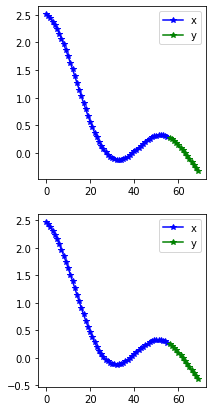

In [ ]:
# hide
dbunch.show_batch(max_n=2)

In [ ]:
# hide
dbunch = TSDataLoaders.from_folder(path, horizon = 14, step=5, bs=64, nrows=100, device = 'cpu')
for o in dbunch.train:
    test_eq(o[0].is_cuda, False)
    break
for o in dbunch.valid:
    test_eq(o[0].is_cuda, False)
    break
    

Train:9672; Valid: 200; Test 100


In [ ]:
# hide
test_eq(dbunch.train.n,9672)
test_eq(dbunch.valid.n,200)
test_eq(dbunch.test.n,100)

In [ ]:
# hide
dl = dbunch.new(shuffle=True)


TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
show_doc(TSDataLoaders.from_items, name='TSDataLoaders.from_items')

<h4 id="TSDataLoaders.from_items" class="doc_header"><code>TSDataLoaders.from_items</code><a href="__main__.py#L18" class="source_link" style="float:right">[source]</a></h4>

> <code>TSDataLoaders.from_items</code>(**`items`**:`L`, **`horizon`**:`int`, **`path`**:`Path`=*`'.'`*, **`valid_pct`**=*`0.5`*, **`seed`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`device`**=*`None`*, **`bs`**=*`64`*, **`norm`**=*`True`*, **`num_workers`**=*`0`*, **`after_batch`**=*`None`*, **`after_item`**=*`None`*, **`shuffle`**=*`False`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`before_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create an list of time series. 

The `DataLoader` for the test set will be save as an attribute under `test_dl`

In [ ]:
show_doc(TSDataLoaders.from_folder, name='TSDataLoaders.from_folder')

<h4 id="TSDataLoaders.from_folder" class="doc_header"><code>TSDataLoaders.from_folder</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>TSDataLoaders.from_folder</code>(**`path`**, **`valid_pct`**=*`0.5`*, **`seed`**=*`None`*, **`horizon`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`device`**=*`None`*, **`nrows`**=*`None`*, **`skiprows`**=*`None`*, **`bs`**=*`64`*, **`norm`**=*`True`*, **`num_workers`**=*`0`*, **`after_batch`**=*`None`*, **`after_item`**=*`None`*, **`shuffle`**=*`False`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`before_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create from M-compition style in `path` with `train`,`test` csv-files. 

The `DataLoader` for the test set will be save as an attribute under `test_dl`

Train:9672; Valid: 200; Test 100


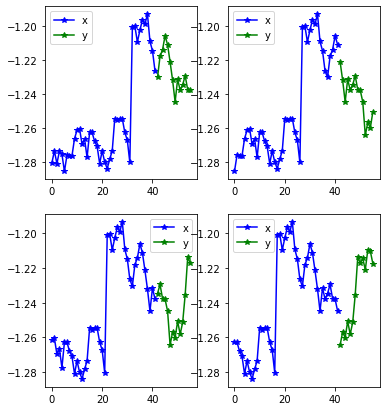

In [ ]:
dbunch = TSDataLoaders.from_folder(path, horizon = 14, step=5, bs=64, nrows=100)
dbunch.train.show_batch(max_n=4)

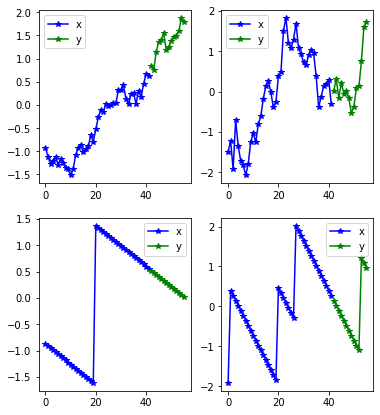

In [ ]:
dbunch.test.show_batch(max_n=4)

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 06_models.dnn.ipynb.
Converted 07_interpret.ipynb.
Converted 08_metrics.ipynb.
Converted 09_learner.ipynb.
Converted 100_readme_alt.ipynb.
Converted 10_models.nbeats.ipynb.
Converted index.ipynb.
